In [1]:
import numpy as np
import scipy
from scipy.signal import spectrogram
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import glob
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
audio_path = "data/train/audio/*/*"
device = "cuda"
seed = 42
train_size = 0.95

spectrogram_params = {
    "fs": 16e3,
    "nperseg": 256,
    "noverlap": 128
}

# Mean / std is calculated from training set
spectrogram_mean = 860.5265
spectrogram_std = 23122.176

In [3]:
file = "data/train/audio/yes/0a7c2a8d_nohash_0.wav"
rate, data = wavfile.read(file)

Frequency dim: (129,), Time dim: (124,)


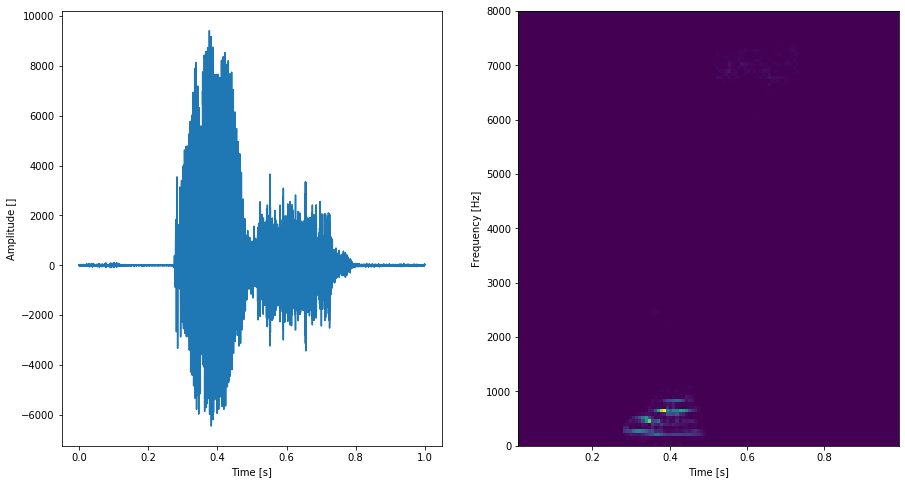

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

f, t, Sxx = spectrogram(data, **spectrogram_params)
ax[1].pcolormesh(t, f, Sxx)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Frequency [Hz]")

ax[0].plot(np.arange(len(data)) / len(data), data)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude []")

print(f"Frequency dim: {f.shape}, Time dim: {t.shape}")
plt.show()

In [5]:
files = glob.glob(audio_path)
files = [file for file in files if "_background_noise_" not in file]

labels = [file.split("\\")[1].strip() for file in files]

label_to_index = {}
for index, label in enumerate(set(labels)):
    label_to_index[label] = index

print(f"Number of classes: {len(label_to_index)}")

Number of classes: 30


In [6]:
random.seed(seed)
random.shuffle(files)
train_files = files[0:int(train_size * len(files))]
test_files = files[int(train_size * len(files)) + 1:]

In [7]:
class AudioData(Dataset):
    def __init__(self, files, label_to_index, spectrogram_params, spectrogram_mean, spectrogram_std):
        self.files = files
        self.label_to_index = label_to_index
        self.spectrogram_params = spectrogram_params
        self.spectrogram_mean = spectrogram_mean
        self.spectrogram_std = spectrogram_std

        self.X = []
        self.Y = []

        for file in self.files:
            x, y = self.create_input_target(file)
            self.X.append(x)
            self.Y.append(y)

        self.X = np.concatenate(self.X)
        self.X = (self.X - self.spectrogram_mean) / (self.spectrogram_std)
        self.X = torch.from_numpy(self.X).float()

        self.Y = np.concatenate(self.Y)
        self.Y = torch.from_numpy(self.Y).long()

    def read_wav(self, file, nsamples=16000):
        _, data = wavfile.read(file)

        if type(data[0]) != np.int16:
            raise ValueError("Not int-16 data!")

        # Padding if sequence is too short
        if data.size < nsamples:
            return np.pad(data, (nsamples - data.size, 0), mode="constant", constant_values=0)
        else:
            return data[0:nsamples]

    def create_input_target(self, file):
        label = file.split("\\")[1].strip()
        assert(label in label_to_index)

        data = self.read_wav(file)
        f, t, x = spectrogram(data, **self.spectrogram_params)
        x = np.transpose(x)
        x = x[None, :, :]

        y = np.array(self.label_to_index[label])
        y = y[None]
        return x, y

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        x = self.X[idx, :, :].to(device)
        y = self.Y[idx].to(device)
        return x, y

In [8]:
batch_size = 128
train_dataset = AudioData(train_files, label_to_index, spectrogram_params, spectrogram_mean, spectrogram_std)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

test_dataset = AudioData(test_files, label_to_index, spectrogram_params, spectrogram_mean, spectrogram_std)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

In [9]:
class RNN(nn.Module):
    def __init__(self, input_dim, num_classes=31, num_hidden=256, num_layers=1, p=0.6):
        super().__init__()
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, num_hidden, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Linear(3 * num_hidden, num_classes)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        output, hT = self.gru(x)

        # Concatenate last hidden, max over all hidden (per dim) and average over all hidden
        output = torch.cat([
            hT[0, :, :],
            torch.max(output, dim=1)[0],
            torch.mean(output, dim=1)
        ], dim=1)

        output = self.dropout(output)
        output = self.linear(output)
        return F.log_softmax(output, dim=1)

In [10]:
torch.manual_seed(seed)
model = RNN(f.shape[0]).to(device)

In [11]:
num_epochs = 20
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [12]:
torch.manual_seed(seed)
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0

    model.train()
    for _, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()

        y_hat = model(x)
        batch_loss = F.nll_loss(y_hat, y)
        batch_loss.backward()
        optimizer.step()

        batch_loss = batch_loss.detach().cpu().numpy()
        train_loss += batch_loss / len(y)

        batch_acc = torch.sum(torch.argmax(y_hat, dim=1) == y).float() / len(y)
        batch_acc = batch_acc.detach().cpu().numpy()
        train_acc += batch_acc

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    test_loss = 0.0
    test_acc = 0.0

    model.eval()
    for _, (x, y) in enumerate(test_dataloader):
        y_hat = model(x)
        batch_loss = F.nll_loss(y_hat, y)

        batch_loss = batch_loss.detach().cpu().numpy()
        test_loss += batch_loss / len(y)

        batch_acc = torch.sum(torch.argmax(y_hat, dim=1) == y).float() / len(y)
        batch_acc = batch_acc.detach().cpu().numpy()
        test_acc += batch_acc

    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    if epoch % 5 == 0 or epoch == (num_epochs - 1):
        print(f"----------- Epoch {epoch} -----------")
        print(f"Train loss: {train_loss}")
        print(f"Test loss: {test_loss}")
        print(f"Train accuracy: {train_acc}")
        print(f"Test accuracy: {test_acc}")

----------- Epoch 0 -----------
Train loss: 0.020265792958555275
Test loss: 0.017244303236818977
Train accuracy: 0.2400110446985447
Test accuracy: 0.4099559291050984
----------- Epoch 5 -----------
Train loss: 0.006461218133497651
Test loss: 0.006783040666268168
Train accuracy: 0.7546157390808613
Test accuracy: 0.7657585464991056
----------- Epoch 10 -----------
Train loss: 0.004472602233373402
Test loss: 0.005254557168182845
Train accuracy: 0.8309600028575335
Test accuracy: 0.8230168269230769
----------- Epoch 15 -----------
Train loss: 0.003502380794588004
Test loss: 0.004603591285900682
Train accuracy: 0.8665097571460224
Test accuracy: 0.8487580120563507
----------- Epoch 19 -----------
Train loss: 0.0029453167016481535
Test loss: 0.004584475774636381
Train accuracy: 0.8876600596364471
Test accuracy: 0.8603098300787119
